In [1]:
import pandas as pd
import numpy as np

In [2]:
# Damped normalization

import numpy as np

def normalize(arr):
    normalized = arr / sum(arr)
    mean = 1 / len(arr)
    return normalized, mean

def damped_normalize(normalized, mean, alpha):
    damped = alpha * mean + (1 - alpha) * normalized
    return damped

def reverse_damped_normalize(damped, mean, alpha):
    original_normalized = (damped - alpha * mean) / (1 - alpha)
    return original_normalized

# Example usage
arr = np.array([10, 20, 30, 40, 50])
alpha = 0.8  # Damping factor

# Step 1: Normalize the original array
normalized, mean = normalize(arr)

# Step 2: Apply damped normalization
damped = damped_normalize(normalized, mean, alpha)

# Step 3: Reverse the damping to get the original normalized values
reversed_normalized = reverse_damped_normalize(damped, mean, alpha)

print("Original array:", arr)
print("Normalized:", normalized)
print("Damped Normalized:", damped)
print("Reversed Normalized:", reversed_normalized)


Original array: [10 20 30 40 50]
Normalized: [0.06666667 0.13333333 0.2        0.26666667 0.33333333]
Damped Normalized: [0.17333333 0.18666667 0.2        0.21333333 0.22666667]
Reversed Normalized: [0.06666667 0.13333333 0.2        0.26666667 0.33333333]


In [3]:
# Load in csv
df = pd.read_csv(r"../../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

In [4]:
class CoilNormalizer():
    def __init__(self):
        super(CoilNormalizer, self).__init__()
        self.max_change_df = None
        self.conserved_subgroups = None
    
    def max_absolute_change(self, df_diff):
        # Calculate the absolute change for each feature
        abs_change = df_diff.abs()

        # Find the maximum absolute change for each feature
        max_changes = abs_change.max()

        # Convert the series to a DataFrame
        max_change_df = max_changes.to_frame(name='Max Absolute Change')

        return max_change_df
    
    def damped_normalize(self,normalized, mean, alpha):
        damped = alpha * mean + (1 - alpha) * normalized
        return damped
    
    def reverse_damped_normalize(damped, mean, alpha):
        original_normalized = (damped - alpha * mean) / (1 - alpha)
        return original_normalized
    
    def normalize(self, df, damping_factor):
        # Calculate the change for each feature
        df_diff = df.diff()

        # Drop first row
        df_diff = df_diff.iloc[1:,:]
        
        # Calculate the max absolute change for each feature
        max_change_df = self.max_absolute_change(df_diff)

        normalized_features = []
        conserved_subgroups = {}
        count = 0
        index = 0
        for column in df_diff.columns:
            max_change_val = max_change_df.loc[column, 'Max Absolute Change']
            normalized_feature = (df_diff[column] + max_change_val) / (2 * max_change_val)
            
            normalized_counter = 1 - normalized_feature
            
            normalized_features.append(normalized_counter)
            normalized_features.append(normalized_feature)
            
            conserved_subgroups[index] = [count, count + 1]
            index += 1
            count += 2
            
        # Create dataframe
        normalized_df = pd.DataFrame(normalized_features).T
        
        # Normalize the dataframe again by row such that each row sums to 1
        renormalized_df = normalized_df.div(normalized_df.sum(axis=1), axis=0)
        
        # Now damp the normalization based on provided damping factor
        damped_normalized = damped_normalize(renormalized_df, mean = 1/renormalized_df.shape[1], alpha = damping_factor)
        
        self.max_change_df = max_change_df
        self.conserved_subgroups = conserved_subgroups
        self.damping_factor = damping_factor

        return damped_normalized
    
    def denormalize(self, damped_normalized_df, initial_value):
        # Remove damping factor
        normalized_df = reverse_damped_normalize(damped_normalized_df, mean = 1/ damped_normalized_df.shape[1], alpha = self.damping_factor)
        
        # For now assume there are even pairs
        denorm_dict = {}
        for key, value in self.conserved_subgroups.items():
            df_sel = normalized_df.iloc[:,value]
            denorm_dict[df_sel.columns[1]] = df_sel.div(df_sel.sum(axis=1), axis=0).iloc[:,1]
            
        denormalized_df = pd.DataFrame(denorm_dict, index=normalized_df.index)
        
        reconstructed_array = []
        new_value = initial_value
        reconstructed_array.append(initial_value)
        delta_max = self.max_change_df.iloc[:,0]
        for i in range(denormalized_df.shape[0]):
            delta_t = 2 * denormalized_df.iloc[i,:] * delta_max - delta_max
            new_value = new_value + delta_t
            reconstructed_array.append(new_value)
        return pd.DataFrame(reconstructed_array, index = [initial_value.name] + list(denormalized_df.index))

In [5]:
# Instantiate CoilNormalizer
coilnormer = CoilNormalizer()

coilnormed_df = coilnormer.normalize(df, damping_factor=0.8)
print(coilnormed_df)

                     p (mbar)  p (mbar)  T (degC)  T (degC)  Tpot (K)  \
Date Time                                                               
2009-01-01 00:20:00  0.035273  0.036155  0.037500  0.033929  0.037489   
2009-01-01 00:30:00  0.036067  0.035362  0.036172  0.035256  0.036169   
2009-01-01 00:40:00  0.035891  0.035538  0.034799  0.036630  0.034759   
2009-01-01 00:50:00  0.035714  0.035714  0.035531  0.035897  0.035578   
2009-01-01 01:00:00  0.035802  0.035626  0.034707  0.036722  0.034668   
...                       ...       ...       ...       ...       ...   
2009-02-04 16:40:00  0.035714  0.035714  0.037546  0.033883  0.037580   
2009-02-04 16:50:00  0.035714  0.035714  0.036767  0.034661  0.036806   
2009-02-04 17:00:00  0.035450  0.035979  0.035714  0.035714  0.035714   
2009-02-04 17:10:00  0.034127  0.037302  0.035989  0.035440  0.035987   
2009-02-04 17:20:00  0.033510  0.037919  0.035165  0.036264  0.035305   

                     Tpot (K)  Tdew (degC)  Tdew (

In [6]:
initial_value = df.iloc[0,:]
coilnormer.denormalize(coilnormed_df,initial_value)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-02-04 16:40:00,971.19,2.16,277.63,-0.30,83.7,7.14,5.98,1.16,3.84,6.15,1225.98,1.55,2.00,12.07
2009-02-04 16:50:00,971.19,1.93,277.39,-0.29,85.2,7.02,5.98,1.04,3.84,6.16,1227.03,1.34,1.88,349.80
2009-02-04 17:00:00,971.22,1.93,277.39,-0.21,85.7,7.02,6.02,1.00,3.86,6.20,1227.04,1.11,1.75,342.00
2009-02-04 17:10:00,971.40,1.87,277.33,-0.24,85.8,6.99,6.00,0.99,3.85,6.18,1227.52,0.80,1.63,312.00


In [7]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-02-04 16:40:00,971.19,2.16,277.63,-0.30,83.7,7.14,5.98,1.16,3.84,6.15,1225.98,1.55,2.00,12.07
2009-02-04 16:50:00,971.19,1.93,277.39,-0.29,85.2,7.02,5.98,1.04,3.84,6.16,1227.03,1.34,1.88,349.80
2009-02-04 17:00:00,971.22,1.93,277.39,-0.21,85.7,7.02,6.02,1.00,3.86,6.20,1227.04,1.11,1.75,342.00


In [8]:
# We should be able to take any slice of the coilnormed timeseries and reproduce
start_index = 200
end_index = 300
df_orig_slice = df.iloc[start_index:end_index,:]
coilnormed_df_slice = coilnormed_df.iloc[start_index:end_index -1,:]
initial_value_slice = df.iloc[start_index,:]

denormed_slice = coilnormer.denormalize(coilnormed_df_slice,initial_value_slice)

In [9]:
import plotly.graph_objects as go
import pandas as pd

# Sample data creation
df1 = denormed_slice
df2 = df_orig_slice

# Plotting
fig = go.Figure()

# Add traces for the first dataframe
for column in df1.columns:
    fig.add_trace(go.Scatter(x=df2.index, y=df1[column], mode='lines', name=f'Denormed: {column}'))

# Add traces for the second dataframe
for column in df2.columns:
    fig.add_trace(go.Scatter(x=df2.index, y=df2[column], mode='lines', name=f'Orig: {column}'))

# Update layout
fig.update_layout(title='Interactive Time Series Plot',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  legend_title='Legend',
                  hovermode='x unified')

# Show the plot
fig.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features, n_batch, device = "cpu"):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.attention_weights = nn.Linear(n_features, 1, bias=False)
        self.act = nn.SiLU()
        self.interaction_tensors = nn.Parameter(torch.randn(n_features, n_features, n_features, n_features + 1))
        self.topk_num = 1
        
        starting_tensor = torch.zeros(n_batch, n_features, n_features)
        if device == "cuda":
            self.starting_transition_tensor = starting_tensor.to("cuda")
        else:
            self.starting_transition_tensor = starting_tensor
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Establish normalized subgroups
        norm_subgroups = torch.cat((state_tensor.unsqueeze(-2), previous_transition_tensor), dim=1)
        batch_size, num_groups, n_features = norm_subgroups.shape
        
        # Compute scores for each normalized subgroup
        scores = self.act(self.attention_weights(norm_subgroups)).sum(-1) # [batch_size, num_groups]
        
        weights = torch.softmax(scores,dim = -1) # [batch_size, num_groups]
        
        selected_interaction_tensors = self.interaction_tensors
        selected_norm_subgroups = norm_subgroups

        #selected_transition_tensors = torch.einsum('ijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
        
        selected_transition_tensors = (torch.mul(selected_interaction_tensors, selected_norm_subgroups.permute(0,2,1).unsqueeze(1).unsqueeze(1))).sum(-2)
        
        # We need a single transition tensor so we will average this as well
        #selected_transition_tensor = torch.einsum('bs,bjks->bjk', weights,selected_transition_tensors)
        
        selected_transition_tensor = (torch.mul(selected_transition_tensors, weights.unsqueeze(-2).unsqueeze(-2))).sum(-1)
        # Generate state tensor from the transition tensor
        # Unsqueezing state_tensor to make it [batch_size, n_features, 1] for matrix multiplication
        state_tensor_unsqueezed = state_tensor.unsqueeze(2)

        # Performing batch matrix multiplication
        new_state_tensor_bmm = torch.bmm(selected_transition_tensor, state_tensor_unsqueezed)

        # Squeezing the result to get rid of the extra dimension, resulting in [batch_size, n_features]
        new_state_tensor = new_state_tensor_bmm.squeeze(2)
    
        softmax_tensor = torch.softmax(new_state_tensor * n_features, dim = 1)
        
        return softmax_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = self.starting_transition_tensor

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


In [12]:
def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)

In [13]:
# Generate and segment the time series
series = coilnormed_df.values
length = 36

series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x.to("cuda")
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y.to("cuda")

In [14]:
n_features = X.shape[2]

In [15]:
from torch import nn, optim

class CoilBlock(nn.Module):
    def __init__(self, n_features, n_batch, device):
        super(CoilBlock, self).__init__()

        self.coil1 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil2 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil3 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
    
    def forward(self, x):
        x, transition_tensor = self.coil1(x)
        x, transition_tensor = self.coil2(x)
        #x, transition_tensor = self.coil3(x)
        return x, transition_tensor
    
# Model
# Single Coil
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch = X.shape[0],
    device="cuda"
).to("cuda")
# Coil Block
# model = CoilBlock(n_features=n_features, n_batch= X.shape[0], device="cuda").to("cuda")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 3000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch [10/3000], Loss: 1.7573522654856788e-06
Epoch [20/3000], Loss: 1.133018713517231e-06
Epoch [30/3000], Loss: 9.076792366613518e-07
Epoch [40/3000], Loss: 8.422291557508288e-07
Epoch [50/3000], Loss: 8.033873086787935e-07
Epoch [60/3000], Loss: 7.839298632461578e-07
Epoch [70/3000], Loss: 7.71709778746299e-07
Epoch [80/3000], Loss: 7.625919238307688e-07
Epoch [90/3000], Loss: 7.554974672530079e-07
Epoch [100/3000], Loss: 7.495962108805543e-07
Epoch [110/3000], Loss: 7.445890446433623e-07
Epoch [120/3000], Loss: 7.402307460324664e-07
Epoch [130/3000], Loss: 7.363800591519976e-07
Epoch [140/3000], Loss: 7.329340405703988e-07
Epoch [150/3000], Loss: 7.298199307115283e-07
Epoch [160/3000], Loss: 7.26982193555159e-07
Epoch [170/3000], Loss: 7.243780828503077e-07
Epoch [180/3000], Loss: 7.219737767627521e-07
Epoch [190/3000], Loss: 7.197425020422088e-07
Epoch [200/3000], Loss: 7.176618623816466e-07
Epoch [210/3000], Loss: 7.157138384172868e-07
Epoch [220/3000], Loss: 7.138832529562933e-0

KeyboardInterrupt: 

In [19]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs.to("cpu"), Y.to("cpu"), batch_index=13, feature_index=0)

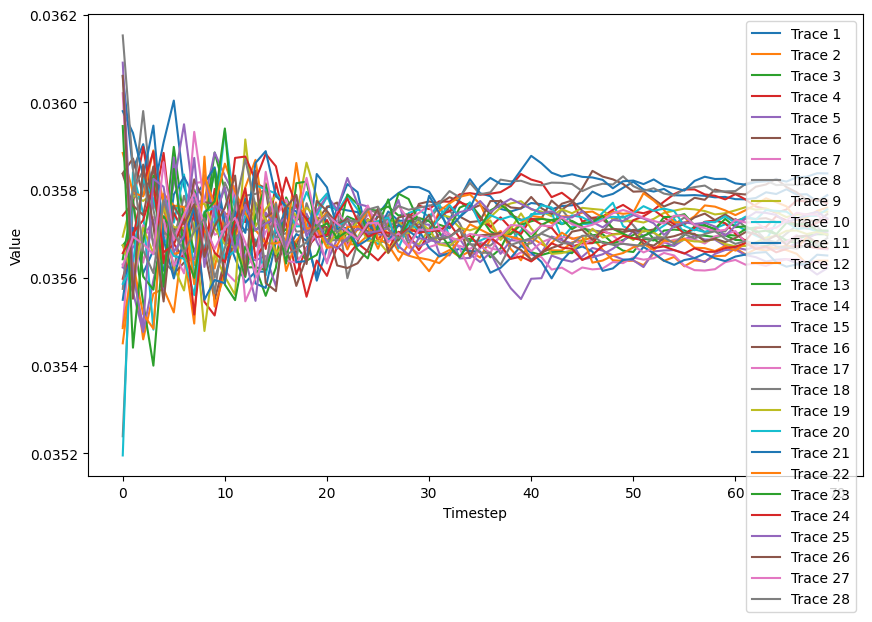

In [20]:
import matplotlib.pyplot as plt

states = []
batch = 15
state_tensor = X[:,0,:]
batch_size = X.shape[0]
transition_tensor = torch.zeros(batch_size, n_features, n_features).to("cuda")
for step_state in range(70):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    #print(sum(state_tensor[batch,:]))
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

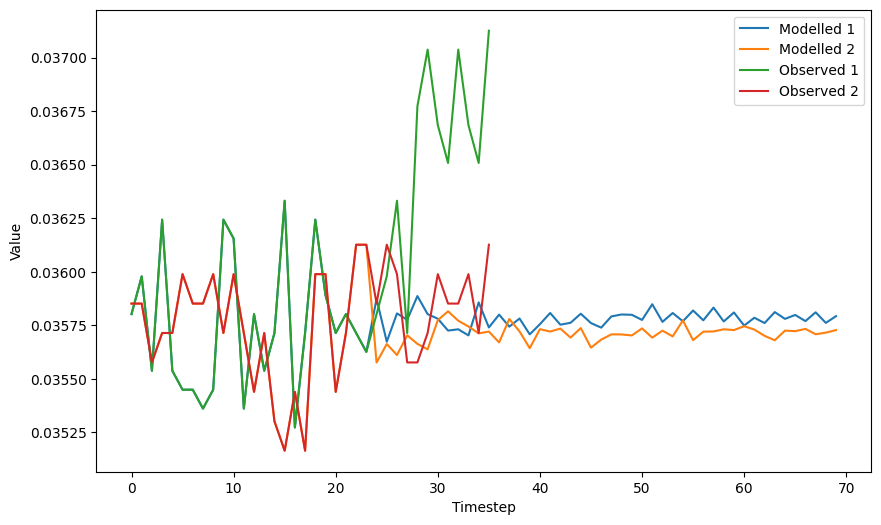

In [21]:
# Try with reconfirmation for part

import matplotlib.pyplot as plt

states = []
batch = 13
feature_sel = [0,13]
state_tensor = X[:,0,:]
batch_size = X.shape[0]
transition_tensor = torch.zeros(batch_size, n_features, n_features).to("cuda")
for step_state in range(70):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    if step_state < 24:
        state_tensor = X[:,step_state,:]
    states.append(state_tensor[batch,feature_sel])
    #print(sum(state_tensor[batch,:]))
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Modelled {i+1}')
    
# Your data
data = X[batch,:,feature_sel].to('cpu')
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Observed {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()